Defining the environment and training an agent (using Q learning) in a 5 x 5 grid world

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

Actions:
* 0 - Left
* 1 - Down
* 2 - Right
* 3 - Up

Agent Position:  1.1

In [ ]:
# Defining GridWorld Environment Class

class MyGridWorld:

    size = 5                        # 5x5 grid
    RewardGrid = np.zeros([5, 5])   # grid representing rewards
    RewardGrid[0][4] = 1            # sets reward in the top-right cell to 1
    PositionGrid = np.zeros([5, 5]) # grid representing the current position of the agent
    PositionGrid[4][0] = 1.1        # sets agent's initial position in the bottom-left cell
    action_space = 4                # no. of possible actions
    noisyMoveChance = 0.3           # probability of noisy move
    currI = 4                       # row index
    currJ = 0                       # col index
    DoneStatus = False              # whether the episode is terminated
    EnableNoise = True              # enable or disable noise
    observation_spaces = size * size # total no. of observations

    # initialize the environment with default values
    def __init__(self, size=5, noisyMoveChance=0.3, EnableNoise=True):
        self.basic_reset()
        self.EnableNoise = EnableNoise
        if 0 < size:
            self.size = int(size)
            self.RewardGrid = np.zeros([size, size])
            self.RewardGrid[0][size-1] = 1
            self.PositionGrid = np.zeros([size, size])
            self.PositionGrid[size-1][0] = 1.1
            self.observation_spaces = self.size * self.size
            self.currI = size-1
            self.currJ = 0
            self.observation_spaces = self.size * self.size
        if 0 < noisyMoveChance < 1:     # probability value
            self.noisyMoveChance = noisyMoveChance

    # resets the environment to its initial state
    def basic_reset(self):
        self.size = 5
        self.RewardGrid = np.zeros([5, 5])
        self.RewardGrid[0][4] = 1
        self.PositionGrid = np.zeros([5, 5])
        self.PositionGrid[4][0] = 1.1
        self.action_space = 4
        self.noisyMoveChance = 0.3
        self.currI = 4
        self.currJ = 0
        self.DoneStatus = False
        self.EnableNoise = True
        self.observation_spaces = self.size * self.size

    # reset environment with parameters
    def reset(self, size=5, noisyMoveChance=0.3, EnableNoise=True):
        self.__init__(size, noisyMoveChance, EnableNoise)
        return self.currI * self.size + self.currJ         # current state of the agent

    # print the reward grid
    def print_reward_grid(self):
        for i in range(len(self.RewardGrid)):
            for j in range(len(self.RewardGrid[0])):
                print(self.RewardGrid[i][j], end=' ')
            print()

    # print the position grid
    def print_position_grid(self):
        for i in range(len(self.PositionGrid)):
            for j in range(len(self.PositionGrid[0])):
                print(self.PositionGrid[i][j], end=' ')

    # print the current state of the position grid
    def render(self):
        self.print_position_grid()

    # return position grid
    def get_position_grid(self):
        return self.PositionGrid

    # return no. of actions
    def get_available_moves(self):
        return self.action_space

    # return size of grid
    def get_size(self):
        return self.size

    # takes an action and updates the agent's position
    def move(self, action):
        rand_num = random.random()
        if self.EnableNoise and rand_num <= self.noisyMoveChance:
            self.make_noisy_move(action)
        else:
            self.make_proper_move(action)
        return self.currI, self.currJ, self.currI * self.size + self.currJ, self.RewardGrid[self.currI][self.currJ], self.DoneStatus

    # noisy move with random action
    def make_noisy_move(self, action):
        rand_num = random.randint(0, 3)
        self.make_proper_move(rand_num)

    # proper move based on given action
    def make_proper_move(self, action):
        if action == 0:  # Left
            if 0 < self.currJ:
                self.PositionGrid[self.currI][self.currJ] = 0
                self.currJ -= 1
                self.PositionGrid[self.currI][self.currJ] = 1.1

        elif action == 1:  # Down
            if self.currI < self.size - 1:
                self.PositionGrid[self.currI][self.currJ] = 0
                self.currI += 1
                self.PositionGrid[self.currI][self.currJ] = 1.1

        elif action == 2:  # Right
            if self.currJ < self.size - 1:
                self.PositionGrid[self.currI][self.currJ] = 0
                self.currJ += 1
                self.PositionGrid[self.currI][self.currJ] = 1.1

        elif action == 3:  # Up
            if 0 < self.currI:
                self.PositionGrid[self.currI][self.currJ] = 0
                self.currI -= 1
                self.PositionGrid[self.currI][self.currJ] = 1.1

        if self.currI == 0 and self.currJ == self.size - 1:   # termination condition reached
            self.DoneStatus = True

    # call move method on action and return output of it
    def step(self, action):
        return self.move(action)

In [ ]:
# Define Q-Learning model training class

class MyGridWorldTrainer:

    env = []                # an instance of environment
    Q = []                  # q value matrix
    matrix = []             # matrix with actions corresponding to the highest q values for each state
    Trajectories = []       # list of trajectories obtained during training
    DirectionalMatrix = []  # matrix with arrows based on the highest q values

    # train a q learning model
    def train_model(self, model):
        env = self.env
        alpha = 0.6    # learning rate
        gamma = 0.9    # discount factor
        Q = np.zeros([env.observation_spaces, env.action_space])

        for episode in range(1, 20001):
            done = False
            total_reward = 0
            state = env.reset()    # reset env

            while not done:
                if episode < 500:    # epsilon-greedy strategy
                    action = random.randint(0, 3)
                else:
                    action = np.argmax(Q[state])
                i, j, state2, reward, done = env.step(action)     # takes an action
                Q[state, action] += alpha * (reward + gamma * np.max(Q[state2]) - Q[state, action])    # update q value
                total_reward += reward
                state = state2

        self.Q = Q    # learned q values matrix
        return Q

    # get optimal directions from learned q values
    def get_directions(self, Q):
        matrix = []

        for i in range(0, 25):
            matrix.append(np.argmax(Q[i]))      # appends the index of the action with maximum Q-value
        matrix = np.reshape(matrix, (5, 5))

        DirectionalMatrix = []
        for i in range(5):
            row = []
            for j in range(5):
                if matrix[i][j] == 0:
                    row.append('\u2190')    # left symbol
                elif matrix[i][j] == 1:
                    row.append('\u2193')    # down symbol
                elif matrix[i][j] == 2:
                    row.append('\u2192')    # right symbol
                elif matrix[i][j] == 3:
                    row.append('\u2191')    # up symbol
            DirectionalMatrix.append(row)

        self.DirectionalMatrix = DirectionalMatrix
        self.matrix = matrix
        return matrix

    # generate trajectories based on optimal actions
    def get_trajectories(self, matrix, num_trajectories):
        Trajectories = []

        for iters in range(num_trajectories):
            path = []       # list for a single trajectory
            done = False
            state = self.env.reset()
            total_reward = 0
            path.append(state)
            i = int(state / self.env.size)    # row index
            j = state % self.env.size         # col index

            # trajectory loop
            while not done:
                action = matrix[i][j]       # retrieve action
                i, j, state2, reward, done = self.env.step(action)    # take action
                total_reward += reward
                state = state2          # update state
                path.append(state)

            Trajectories.append(path)

        self.Trajectories = Trajectories
        return Trajectories

    # all training functions
    def all_in_one(self, model, num_trajectories):
        self.env = model
        Q = self.train_model(model)
        matrix = self.get_directions(Q)
        return self.get_trajectories(matrix, num_trajectories)

In [ ]:
# Sample case
sample_grid = MyGridWorld()
sample_grid_trainer = MyGridWorldTrainer()
sample_trajectories = sample_grid_trainer.all_in_one(sample_grid, 20)     # training (Q Learning)

print('Policy: \n')
for direction in sample_grid_trainer.matrix:
    print(direction)

print('\nPolicy (directions): \n')
for row in sample_grid_trainer.DirectionalMatrix:
    print(row)

print('\nQ value matrix: \n')
for row in sample_grid_trainer.Q:   # Q value for each state action pair
    print(row)

print('\nTrajectories: \n')
for trajectory in sample_trajectories:
    print(trajectory)

Policy: 

[2 2 2 2 0]
[2 2 2 3 3]
[3 2 3 3 3]
[3 3 2 3 3]
[3 2 3 3 3]

Policy (directions): 

['→', '→', '→', '→', '←']
['→', '→', '→', '↑', '↑']
['↑', '→', '↑', '↑', '↑']
['↑', '↑', '→', '↑', '↑']
['↑', '→', '↑', '↑', '↑']

Q value matrix: 

[0.38597315 0.3924136  0.57806635 0.38274343]
[0.40611118 0.41261482 0.61341328 0.40060789]
[0.50077369 0.50708175 0.8511142  0.52705024]
[0.53330832 0.56008937 0.99957194 0.56292468]
[0. 0. 0. 0.]
[0.33325697 0.33235593 0.54588019 0.34147924]
[0.37286485 0.37178583 0.47806293 0.38966255]
[0.43214679 0.4526809  0.69743106 0.42176566]
[0.4888402  0.48561965 0.47466286 0.89198169]
[0.49368871 0.52518641 0.52614331 0.83087097]
[0.28855123 0.29455471 0.30451311 0.498456  ]
[0.33251831 0.34474018 0.55329542 0.34614464]
[0.37922853 0.36191    0.39019635 0.55386944]
[0.43352886 0.38945798 0.43482199 0.79475625]
[0.44395005 0.43431342 0.45099019 0.83562989]
[0.26765687 0.24645907 0.27056951 0.42972728]
[0.27802601 0.26417854 0.27573802 0.43195702]
[0.3013

In [ ]:
# Define function to visualize the grid and agent's movements

def visualize_trajectories(grid, trajectories):
    num_trajectories = len(trajectories)
    num_cols = min(num_trajectories, 5)
    num_rows = (num_trajectories - 1) // num_cols + 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))
    axs = axs.flatten()

    for i in range(num_trajectories):
        ax = axs[i]
        ax.set_xticks(range(grid.size))
        ax.set_yticks(range(grid.size))
        ax.grid()

        # initial agent position
        state = trajectories[i][0]
        ii, jj = divmod(state, grid.size)
        ax.plot(jj + 0.5, grid.size - 1 - ii + 0.5, 'kh', markersize=20)  # agent position

        # plot agent's movements
        for t in range(1, len(trajectories[i])):
            next_state = trajectories[i][t]
            next_ii, next_jj = divmod(next_state, grid.size)
            ax.arrow(jj + 0.5, grid.size - 1 - ii + 0.5,
                     next_jj - jj, ii - next_ii,
                     head_width=0.1, head_length=0.1, fc='r', ec='r')    # position of arrows (of movement)
            ii, jj = next_ii, next_jj

        ax.set_title(f'Trajectory {i + 1}')

    plt.tight_layout()
    plt.show()

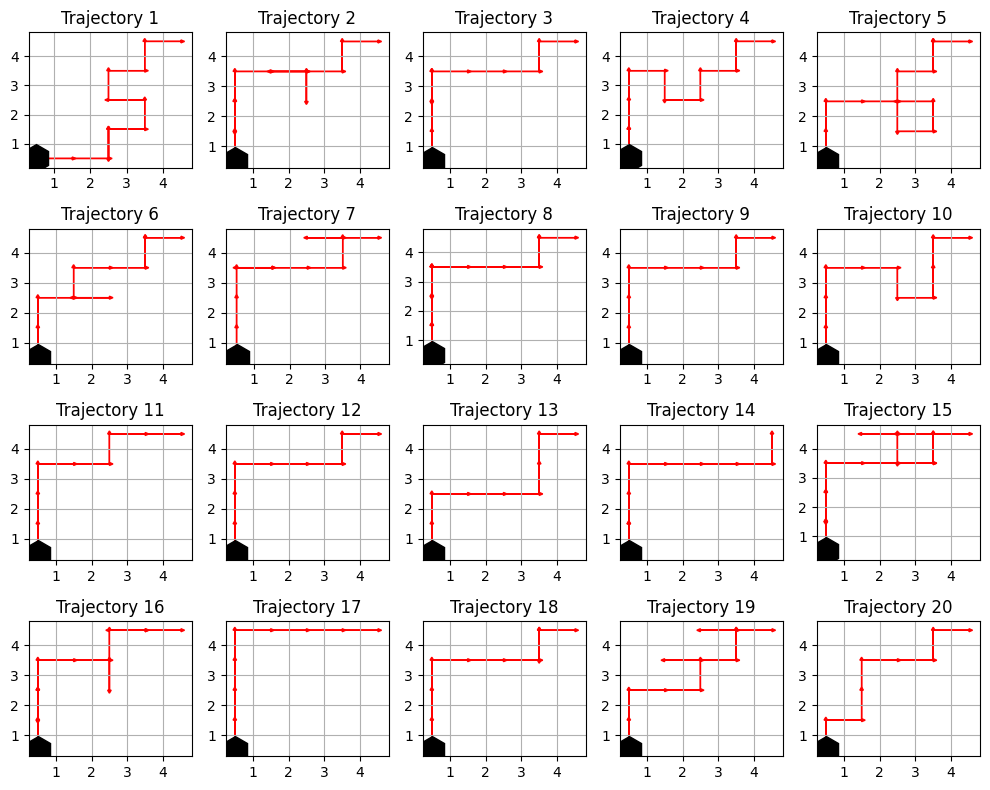

In [ ]:
visualize_trajectories(sample_grid, sample_trajectories)